In [1]:
import notebookimport

In [2]:
import sqlite3
import pandas as pd

In [3]:
if __name__=='__main__':
    %matplotlib inline

In [4]:
if __name__=='__main__':
    dbname='wrc18.db'
    conn = sqlite3.connect(dbname)

    q="SELECT name FROM sqlite_master WHERE type = 'table';"
    display(pd.read_sql(q,conn))

,name
0,itinerary_event
1,itinerary_legs
2,itinerary_sections
3,itinerary_stages
4,itinerary_controls
5,startlists
6,startlist_classes
7,penalties
8,retirements
9,stagewinners


In [5]:
sr = __import__("Charts - Stage Results")

importing Jupyter notebook from Charts - Stage Results.ipynb


In [6]:
if __name__=='__main__':
    year=2018
    rc='RC2'
    ss='SS4'
    rally='Sweden'

    typ='stage_times_stage' #stage_times_stage stage_times_overall
    typ='stage_times_overall'

In [7]:
if __name__=='__main__':
    rally_stages = sr.dbGetRallyStages(conn, rally)
    stagerank = sr.dbGetStageRank(conn, rally, rc)

## Rally Delta Charts

Macroscope intended to show gaps between cars on each stage of a rally.

In [63]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter

In [20]:
if __name__=='__main__':
    rebase = stagerank[stagerank['classrank']==1][['snum','totalTimeMs']].set_index('snum').to_dict(orient='dict')['totalTimeMs']
    display(rebase)

{1: 96800,
 2: 766200,
 3: 1607100,
 4: 2282900,
 5: 2937500,
 6: 3770500,
 7: 4418400,
 8: 4821500,
 9: 5467600,
 10: 6293200,
 11: 6831100,
 12: 7463500,
 13: 8276200,
 14: 8809100,
 15: 8907800,
 16: 9069400,
 17: 9794900,
 18: 10502700,
 19: 10887500}

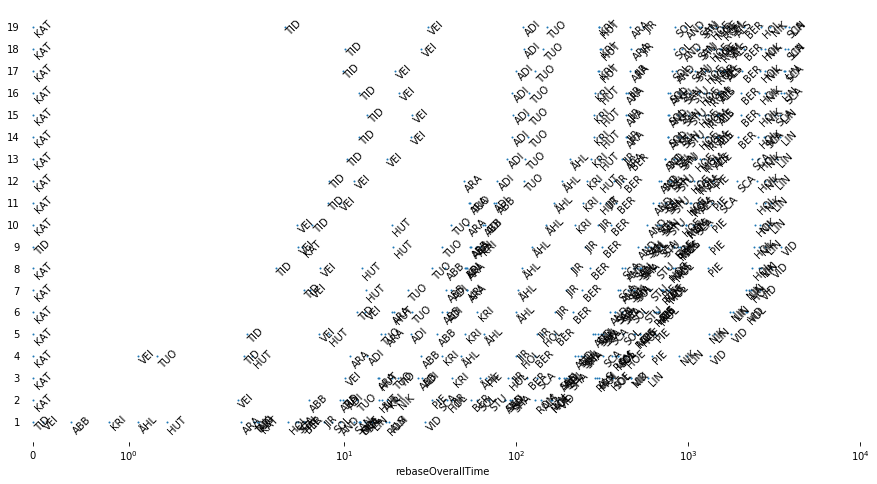

In [22]:
if __name__=='__main__':
    ## Plot Stage Times
    fig, ax = plt.subplots(figsize=(15,8))
    ax.yaxis.label.set_visible(False)
    ax.tick_params(axis='y', which='both',length=0)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    plt.xscale('symlog')
    plt.box(on=None)
    stagerank['rebaseOverallTime']  = ((stagerank['totalTimeMs'] - stagerank['snum'].map(rebase))/1000).round(1)
    stagerank.plot(kind='scatter',y='snum',x='rebaseOverallTime',xlim=(-0.1,10000),s=1,ax=ax )

    for i, row in stagerank.iterrows():
        ax.annotate(row['drivercode'], (stagerank.iloc[i]['rebaseOverallTime'],stagerank.iloc[i]['snum']), rotation=45)

In [24]:
if __name__=='__main__':
    #show deltas for target driver
    drivercode='HUT'
    rebase= stagerank[stagerank['drivercode']==drivercode][['snum','totalTimeMs']].set_index('snum').to_dict(orient='dict')['totalTimeMs']
    display(rebase)

{1: 98200,
 2: 782000,
 3: 1622900,
 4: 2285800,
 5: 2945600,
 6: 3789800,
 7: 4431700,
 8: 4834100,
 9: 5486800,
 10: 6312000,
 11: 7135800,
 12: 7765900,
 13: 8580100,
 14: 9116200,
 15: 9215000,
 16: 9374000,
 17: 10097500,
 18: 10811400,
 19: 11189600}

In [61]:
def plotDeltaLabels(stagerank, rebaseType='position', drivercode=None, logscale=True, 
                    xlim=None, ylim=None, title=None, **kwargs):
    ''' 
        The deltas are based on class position
        rebaseType: driver | position 
    '''
    if rebaseType=='driver' and drivercode is not None:
        rebase= stagerank[stagerank['drivercode']==drivercode][['snum','totalTimeMs']].set_index('snum').to_dict(orient='dict')['totalTimeMs']
    else:
        rebase= stagerank[stagerank['classrank']==1][['snum','totalTimeMs']].set_index('snum').to_dict(orient='dict')['totalTimeMs']

    fig, ax = plt.subplots(figsize=(15,8))
    plt.box(on=None)
    
    ax.yaxis.label.set_visible(False)
    
    
    #https://stackoverflow.com/a/15124785/454773
    def mjrFormatter(x, pos):
        return "SS{}".format(int(x))
    
    ax.yaxis.set_major_formatter(FuncFormatter(mjrFormatter))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.tick_params(axis='y', which='both',length=0)

    
    if logscale:
        plt.xscale('symlog')
    
    plt.axvline(x=0,linestyle='dashed',color='grey')
    
    title = 'Overall Deltas by Stage' if title is None else title
    title = '{} (relative to {})'.format(title, drivercode) if drivercode else title
    
    stagerank['rebaseOverallTime']  = ((stagerank['totalTimeMs'] - stagerank['snum'].map(rebase))/1000).round(1)
    stagerank.plot(kind='scatter',y='snum', x='rebaseOverallTime',s=1, ax=ax, xlim=xlim, ylim=ylim ,
                   title = title)

    #labels = ['z' for item in ax.get_yticklabels()]
    #ax.set_yticklabels(labels)

    for i, row in stagerank.iterrows():
        if xlim is not None:
            if stagerank.iloc[i]['rebaseOverallTime']>=xlim[0] and stagerank.iloc[i]['rebaseOverallTime']<=xlim[1]:
                if row['drivercode'] != drivercode:
                    col='g' if row['rebaseOverallTime']<0 else 'r'
                    txt = '{} [{}]'.format(row['drivercode'],row['position'])
                else:
                    col='black'
                    txt = row['position']
                
                ax.annotate(txt,
                            (row['rebaseOverallTime'],row['snum']),color=col, rotation=45)
                
    if kwargs is not None and 'filename' in kwargs:
        fig.savefig(kwargs['filename'])
        
    return fig,ax

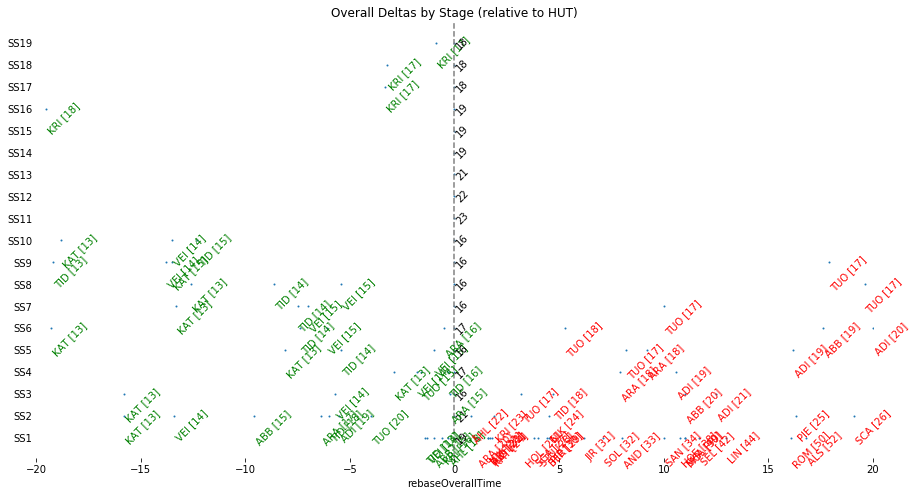

In [62]:
if __name__=='__main__':
    plotDeltaLabels(stagerank, 'driver','HUT',logscale=False,xlim=(-20,20))